In [1]:
from pymoo.core.problem import ElementwiseProblem  # Add this import statement
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.termination.xtol import DesignSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.optimize import minimize

import joblib 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# %run 1.Sobol_sequence.ipynb
%run 2.Hicks_Henne_NEW_Final.ipynb
# %run 3.Deformed_foil_generator.ipynb
# %run 4.Xfoil_runner_extract_value.ipynb
# %run 5.ANN_MODEL.ipynb

In [2]:
model = joblib.load('model__01.joblib')
scaler = joblib.load('scaler_file__01.joblib')

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]

In [4]:
class MyProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=8,
                         n_obj=1,
                         n_ieq_constr=1,
                         xl=np.array([-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01]),
                         xu=np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]))

    def _evaluate(self, x, out, *args, **kwargs):
        # print("Shape of x:", x.shape)
        # print("Size of x:", x.size)
        # Reshape and transform design parameters
        design_parameters = x.reshape(1, 8)
        design_parameters = pd.DataFrame(design_parameters, columns=feature_names)
        design_parameters = scaler.transform(design_parameters)

        # Get predictions from the model
        predictions = model.predict(design_parameters)
        CL = predictions[0, 0]
        CD = predictions[0, 1]

        # Calculate efficiency
        efficiency = CL / CD

        # Apply constraint
        original_CD =0.00848
        constraint_val = CD - original_CD

        out["F"] = -efficiency  # Objective
        out["G"] = constraint_val  # Constraint

In [19]:
# Define the problem
problem = MyProblem()

# Define the NSGA-II algorithm
# algorithm = get_algorithm("nsga2", pop_size=100)
# algorithm = NSGA2(pop_size=4, n_offsprings=10, sampling=FloatRandomSampling(), crossover=SBX(prob=0.9, eta=15), mutation=PM(eta=20),
#                   eliminate_duplicates=True)

algorithm = NSGA2(pop_size=40, n_offsprings=10, sampling=FloatRandomSampling())

# Define the termination criterion
termination = get_termination("n_gen", 100)
# termination = RobustTermination(DesignSpaceTermination(tol=0.01))



# Perform optimization
res = minimize(problem,
               algorithm,
               termination,
               seed=1,  # Set a seed for reproducibility
               verbose=False)

# Get the optimal design parameters
optimal_design_parameters = res.X

# Negate the objective value to obtain the maximized efficiency
maximized_efficiency = -res.F[0]

1/1 [==============================] - 0s 27ms/step


In [6]:
optimal_design_parameters

array([ 0.00999558,  0.00998877, -0.00996697,  0.00997991,  0.00996948,
        0.00997019,  0.00999818,  0.00999663])

In [7]:
optimal_design_parameters = np.array(optimal_design_parameters).reshape((1, 8))
optimal_design_parameters_df = pd.DataFrame(optimal_design_parameters, columns=feature_names)
optimal_design_parameters_scaled = scaler.transform(optimal_design_parameters_df)
Optimized = model.predict(optimal_design_parameters_scaled)
CL_opt = Optimized[0, 0]
CD_opt = Optimized[0, 1]
optimal_efficiency = CL_opt/CD_opt
print("Optimal Design Parameters:", optimal_design_parameters)
print("Optimal Lift Coefficient:", CL_opt )
print("Optimal Drag Coefficient:", CD_opt)
print("Optimal Aerodynamic Efficiency:", optimal_efficiency)
print("Optimal Aerodynamic Efficiency:", maximized_efficiency)

1/1 [==============================] - 0s 36ms/step
Optimal Design Parameters: [[ 0.00999558  0.00998877 -0.00996697  0.00997991  0.00996948  0.00997019
   0.00999818  0.00999663]]
Optimal Lift Coefficient: 0.7904607
Optimal Drag Coefficient: 0.007754745
Optimal Aerodynamic Efficiency: 101.93252
Optimal Aerodynamic Efficiency: 101.9325180053711


In [8]:
i = 0

In [9]:
y_opt = hicks_henne_overall(x, y , n, optimal_design_parameters, i, w, xM)

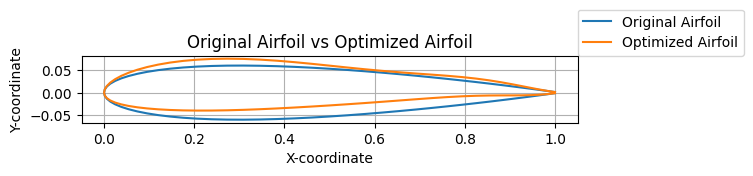

In [10]:
plt.plot(x, y, label = "Original Airfoil")
plt.plot(x, y_opt, label = "Optimized Airfoil")
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Original Airfoil vs Optimized Airfoil')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend(loc=(1,1))
plt.grid()

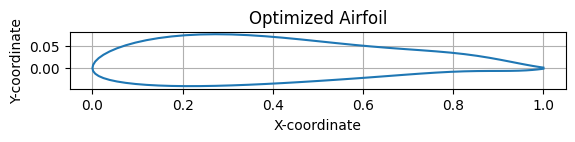

In [11]:
plt.plot(x,y_opt)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Optimized Airfoil')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid()

In [12]:
df_opt = pd.DataFrame({'x': x, 'y_modified': y_opt})
path = "Optimized_airfoil.dat"
df_opt.to_csv(path, index=False, sep=' ')

In [13]:
import os
import subprocess
import numpy as np
import pandas as pd
import time
import warnings

In [14]:
# %% Inputs
# alpha_i = 0
# alpha_f = 5
# step = 1
alpha = 5
Re = 1000000
# Mach = 0.2
n_iter = 20
# n_panels = 200

In [15]:
airfoil_name = "Optimized_airfoil"

if os.path.exists("polar_file.txt"):
    os.remove("polar_file.txt")
    
input_file = open("input_file.in", 'w')
input_file.write("LOAD {0}.dat\n".format(airfoil_name))
input_file.write(airfoil_name + '\n')
#     input_file.write("PANE\nN {0}".format(n_panels))
input_file.write("PANE\n")
input_file.write("OPER\n")
input_file.write("Visc {0}\n".format(Re))
#     input_file.write("Mach {0}\n".format(Mach))
input_file.write("PACC\n")
input_file.write("polar_file.txt\n\n")
input_file.write("ITER {0}\n".format(n_iter))
#     input_file.write("Aseq {0} {1} {2}\n".format(alpha_i,alpha_f,step))
input_file.write("Alfa {0}\n".format(alpha))
input_file.write("\n\n")
input_file.write("quit\n")
input_file.close()

subprocess.call(f'xfoil.exe < input_file.in & echo quit', shell=True)

time.sleep(0.5)

with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")

    # Try to load data from the file
    polar_data = np.loadtxt("polar_file.txt", skiprows=12)

    # Check for the specific UserWarning
    for warning in w:
        if issubclass(warning.category, UserWarning) and "input contained no data" in str(warning.message):
#                 print(f"Warning encountered in iteration {i}: {warning.message}")
            break  # Stop checking for warnings once the relevant one is found

if len(polar_data)==0:
    CL = np.nan
    CD = np.nan
    print("-------->","NaN","NaN")

else:
    CL = polar_data[1]
    CD = polar_data[2]
    print("-------->",polar_data[1],polar_data[2])
    print("-------->",polar_data[1]/polar_data[2])
    

--------> 0.7936 0.00775
--------> 102.39999999999999


In [16]:
print('Surrogate model optimization:')
print("Optimal Design Parameters:", optimal_design_parameters)
print("Optimal Lift Coefficient(Surrogate model prediction):", CL_opt )
print("Optimal Drag Coefficient(Surrogate model prediction):", CD_opt)
print("Optimal Aerodynamic Efficiency:", optimal_efficiency)
print("Lift Coefficient for Optimal Design Parameter from XFOIL:", CL )
print("Drag Coefficient for Optimal Design Parameter from XFOIL:", CD)
Opt_eff = CL/CD
print("Optimal Aerodynamic Efficiency from XFOIL:", Opt_eff)

Surrogate model optimization:
Optimal Design Parameters: [[ 0.00999558  0.00998877 -0.00996697  0.00997991  0.00996948  0.00997019
   0.00999818  0.00999663]]
Optimal Lift Coefficient(Surrogate model prediction): 0.7904607
Optimal Drag Coefficient(Surrogate model prediction): 0.007754745
Optimal Aerodynamic Efficiency: 101.93252
Lift Coefficient for Optimal Design Parameter from XFOIL: 0.7936
Drag Coefficient for Optimal Design Parameter from XFOIL: 0.00775
Optimal Aerodynamic Efficiency from XFOIL: 102.39999999999999


In [17]:
print("Error%")
print("Lift Coefficient Error:", abs((CL_opt-CL)*100/CL))
print("Drag Coefficient Error:", abs((CD_opt-CD)*100/CD))
print("Optimal Aerodynamic Efficiency Error:", abs((Opt_eff-optimal_efficiency)*100/Opt_eff))

Error%
Lift Coefficient Error: 0.39557639148927154
Drag Coefficient Error: 0.06122531429413898
Optimal Aerodynamic Efficiency Error: 0.456525385379783


In [18]:
CL_org = 0.5572
CD_org = 0.00848
Org_Eff = CL_org/CD_org
print("Improvement in Efiiciency")
print("Lift and Drag Coefficient of Original Airfoil:", CL_org , CD_org)
print("Efiiciency of Original Airfoil:", CL_org/CD_org)
print("Lift and Drag Coefficient of Optimized Airfoil:", CL ,CD)
print("Efiiciency of Optimized Airfoil:", Opt_eff)
print("Improvement in Efiiciency:", abs((Opt_eff-Org_Eff)*100/Org_Eff),"%")

Improvement in Efiiciency
Lift and Drag Coefficient of Original Airfoil: 0.5572 0.00848
Efiiciency of Original Airfoil: 65.70754716981132
Lift and Drag Coefficient of Optimized Airfoil: 0.7936 0.00775
Efiiciency of Optimized Airfoil: 102.39999999999999
Improvement in Efiiciency: 55.84206748025842 %
